Fuente: https://cienciadedatos.net/documentos/py51-modelos-arima-sarimax-python

#Librerías

In [1]:
# Librerías
# ======================================================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import GridSearchCV

# 1- Datos

##  Descarga datos

In [2]:
url = 'https://raw.githubusercontent.com/MarianaDiazNobile/IPC/main/Base%20de%20datos_IPC_.csv'
# Leer el archivo CSV especificando el encoding
datos = pd.read_csv(url, encoding='ISO-8859-1', delimiter=';') #uso delimiter para especificar que el texto está separado con ;
#datos.head(5)

In [3]:
datos = datos.rename(columns={'Fecha':'date', 'IPC Cba nivel general, base agos=100':'IPC_NG','IPC Cba Inflación Núcleo':'IPC_Nucleo',
                              'Base monetaria (M0), saldos a fin de mes en millones de pesos': 'M0', 'M2_moneda_nacional':'M2_pesos',
                              'M2_moneda_extranjera': 'M2_ME', 'M3_moneda_nacional':'M3_pesos',
                              'M3_moneda_extranjera': 'M3_ME','M3_total_moneda_extranjera': 'M3_Total_ME'})


In [4]:
#display(datos.head(4))

In [5]:
datos['date'] = pd.to_datetime(datos['date'], format='%Y-%m')
datos = datos.set_index('date')
datos = datos.loc['2013-08-01 00:00:00':'2023-11-01 00:00:00']
datos = datos.asfreq('MS')
display(datos.head(4))

,IPC_NG,IPC_Nucleo,M0,M2,M2_pesos,M2_ME,M3,M3_pesos,M3_ME,M3_Total,M3_total_pesos,M3_Total_ME,TCN,emae_des,emae_orig
date,,,,,,,,,,,,,,,
2013-08-01,100.0,100.0,321192.0,544146.0,525617.0,18529.0,898528.0,853184.0,45344.0,900006.0,854642.0,45365.0,6.0,150.0,148.0
2013-09-01,101.0,101.0,327433.0,564597.0,544510.0,20087.0,923418.0,876071.0,47347.0,924669.0,877303.0,47367.0,6.0,150.0,147.0
2013-10-01,103.0,103.0,326803.0,560851.0,540311.0,20540.0,937694.0,889611.0,48083.0,938835.0,890732.0,48103.0,6.0,149.0,149.0
2013-11-01,105.0,106.0,336846.0,572556.0,550702.0,21854.0,955017.0,904815.0,50202.0,956164.0,905947.0,50218.0,6.0,148.0,146.0


In [6]:
# Verificar que un índice temporal está completo (para ver si no hay huecos )
# ==============================================================================
(datos.index == pd.date_range(start=datos.index.min(),
                              end=datos.index.max(),
                              freq=datos.index.freq)).all()

True

# 2 -  Análisis y Visualización de los datos

In [7]:
datos.describe()

,IPC_NG,IPC_Nucleo,M0,M2,M2_pesos,M2_ME,M3,M3_pesos,M3_ME,M3_Total,M3_total_pesos,M3_Total_ME,TCN,emae_des,emae_orig
count,124.000000,124.000000,1.240000e+02,1.240000e+02,1.240000e+02,1.240000e+02,1.240000e+02,1.240000e+02,1.240000e+02,1.240000e+02,1.240000e+02,1.240000e+02,124.000000,124.000000,124.000000
mean,929.798387,885.008065,1.913642e+06,5.138225e+06,4.186298e+06,9.519270e+05,8.660049e+06,7.373546e+06,1.286504e+06,8.706844e+06,7.416018e+06,1.290826e+06,65.927419,144.838710,144.701613
std,1218.577746,1184.104591,1.801073e+06,6.203887e+06,5.162992e+06,1.063726e+06,1.080409e+07,9.462043e+06,1.375447e+06,1.085930e+07,9.512337e+06,1.380262e+06,78.956319,6.873286,9.560233
min,100.000000,100.000000,3.211920e+05,5.441460e+05,5.256170e+05,1.852900e+04,8.985280e+05,8.531840e+05,4.534400e+04,9.000060e+05,8.546420e+05,4.536500e+04,6.000000,106.000000,113.000000
25%,201.500000,196.000000,5.753718e+05,1.088188e+06,9.940400e+05,1.072088e+05,1.776266e+06,1.588908e+06,2.019515e+05,1.778154e+06,1.590864e+06,2.020508e+05,14.000000,144.000000,138.000000
50%,420.500000,382.500000,1.223584e+06,2.669908e+06,1.830751e+06,8.614365e+05,4.359674e+06,3.178200e+06,1.194588e+06,4.383463e+06,3.198898e+06,1.199395e+06,37.000000,146.000000,146.000000
75%,1105.250000,1033.750000,2.490282e+06,6.338466e+06,5.067104e+06,1.271362e+06,1.068927e+07,8.937981e+06,1.752342e+06,1.075392e+07,8.996305e+06,1.757620e+06,94.250000,149.000000,150.000000
max,6471.000000,6365.000000,8.973530e+06,2.926760e+07,2.469369e+07,4.669615e+06,4.803651e+07,4.219039e+07,5.979399e+06,4.829652e+07,4.243388e+07,6.002194e+06,361.000000,153.000000,169.000000


### M0

<ipython-input-8-1dcef41a9d0a>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=datos.sort_values('date'), x='date', y='M0', estimator=np.sum, ci=None)


Text(0.5, 1.0, 'M0')

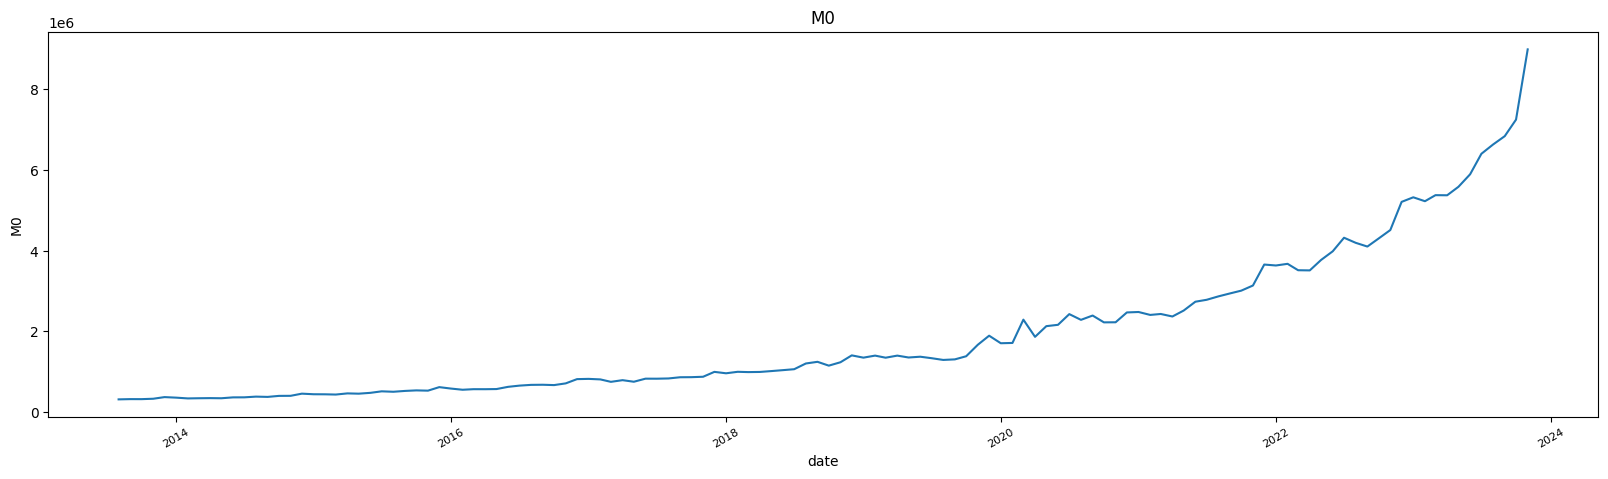

In [8]:
fig = plt.figure(figsize=(20, 5))

sns.lineplot(data=datos.sort_values('date'), x='date', y='M0', estimator=np.sum, ci=None)
plt.xticks(rotation=30, size=8);
plt.title('M0')

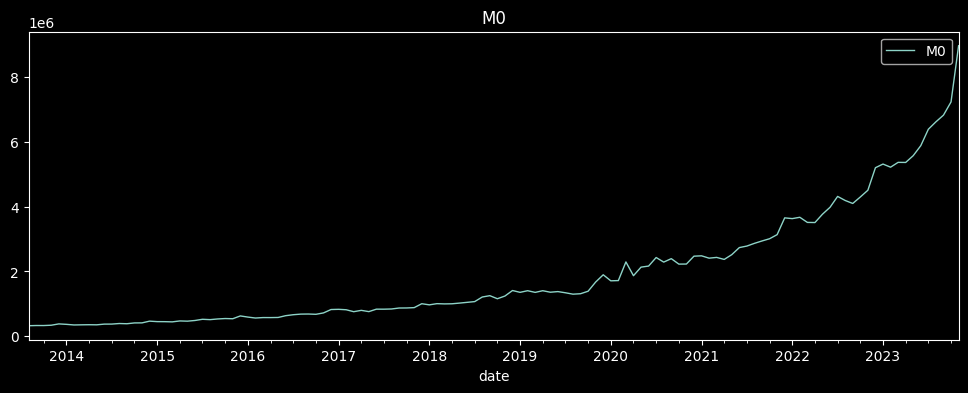

In [ ]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 4))
datos.M0.plot(ax=ax, label='M0', linewidth=1)
ax.set_title('M0')
ax.legend();

<Axes: xlabel='M0'>

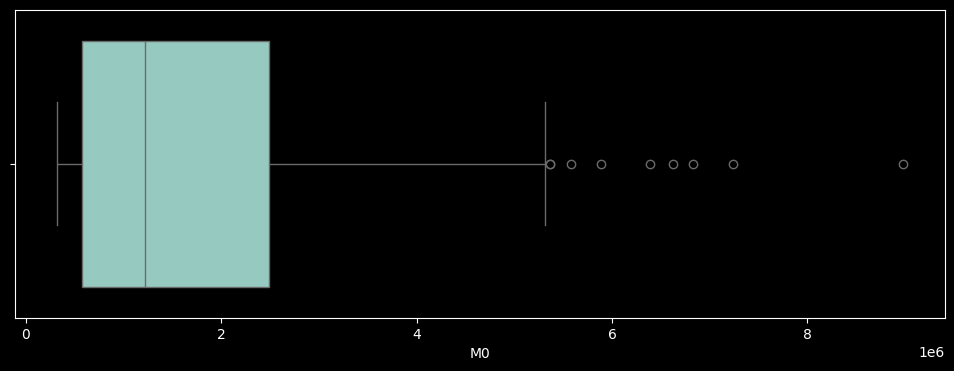

In [ ]:
plt.figure(figsize=(12, 4))
sns.boxplot(x=datos['M0'])

In [ ]:
# Calcular el rango intercuartil (IQR)
Q1 = datos['M2'].quantile(0.25)
Q3 = datos['M2'].quantile(0.75)
IQR = Q3 - Q1

# Calcular los límites de los bigotes
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar los outliers
outliers = datos[(datos['M2'] < lower_bound) | (datos['M2'] > upper_bound)]

print("Valores atípicos:")
print(outliers)

Valores atípicos:
            IPC_NG  IPC_Nucleo         M0          M2    M2_pesos      M2_ME  \
date                                                                           
2022-12-01  2619.0      2475.0  5203751.0  15741283.0  13088357.0  2652926.0   
2023-01-01  2760.0      2585.0  5316722.0  15600267.0  12771023.0  2829244.0   
2023-02-01  2968.0      2812.0  5219956.0  16497591.0  13550303.0  2947288.0   
2023-03-01  3205.0      3066.0  5369482.0  16454263.0  13436661.0  3017601.0   
2023-04-01  3414.0      3282.0  5366599.0  17599027.0  14573629.0  3025397.0   
2023-05-01  3686.0      3526.0  5576415.0  18765888.0  15518846.0  3247042.0   
2023-06-01  3884.0      3741.0  5885739.0  20541000.0  17075267.0  3465733.0   
2023-07-01  4148.0      4002.0  6392700.0  22010282.0  18158987.0  3851295.0   
2023-08-01  4653.0      4550.0  6621931.0  24406428.0  19801974.0  4604455.0   
2023-09-01  5297.0      5178.0  6828209.0  26491968.0  21875681.0  4616288.0   
2023-10-01  5732.0    

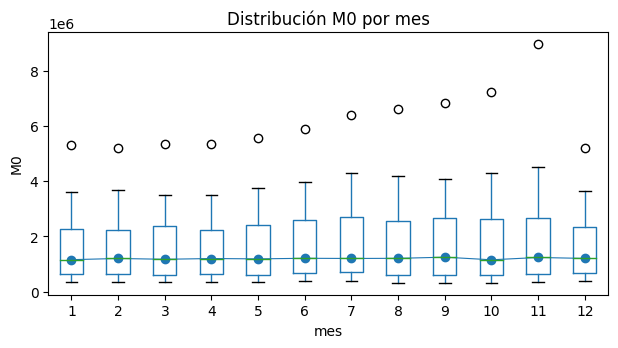

In [ ]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
plt.style.use('default')
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['mes'] = datos.index.month
datos.boxplot(column='M0', by='mes', ax=ax,)
datos.groupby('mes')['M0'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('M0')
ax.set_title('Distribución M0 por mes')
fig.suptitle('');

(0.0, 800000.0)

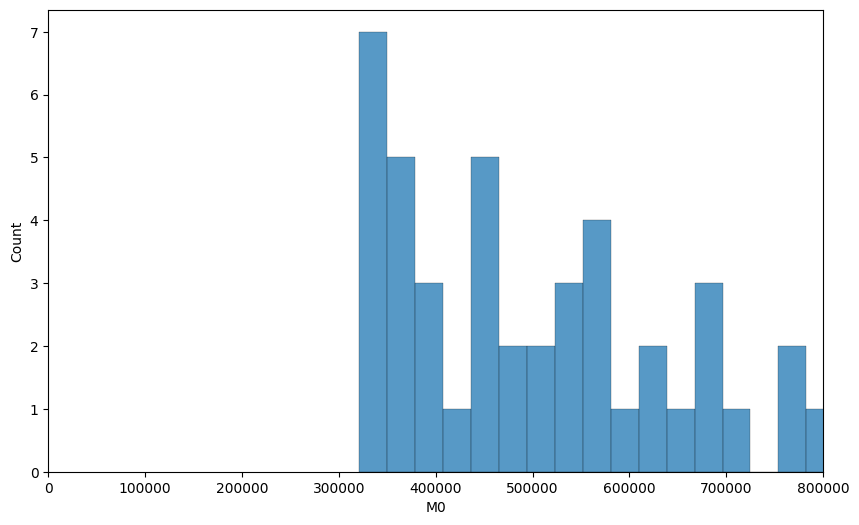

In [ ]:
fig = plt.figure(figsize=(10,6))
fig = sns.histplot(x= datos['M0'], bins=300)
plt.ticklabel_format(style='plain', axis='x')
plt.xlim(0,800000)

In [ ]:
datos['año'] = datos.index.year

In [ ]:
# Rango de años disponibles
años = range(2013, 2024)

# Crear una figura
plt.figure(figsize=(10, 5))

# Iterar sobre los años y graficar cada uno
for año in años:
    datos_año = datos[str(año)]
    plt.plot(datos_año['mes'], datos_año['M0'], label=str(año))

# Configurar el título, etiquetas de los ejes y leyenda
plt.title('M0 para varios años')
plt.xlabel('Mes')
plt.ylabel('M0')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

KeyError: '2013'

<Figure size 1000x500 with 0 Axes>

<ipython-input-12-f5dbb5ad77dd>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  datos_año = datos[str(año)]


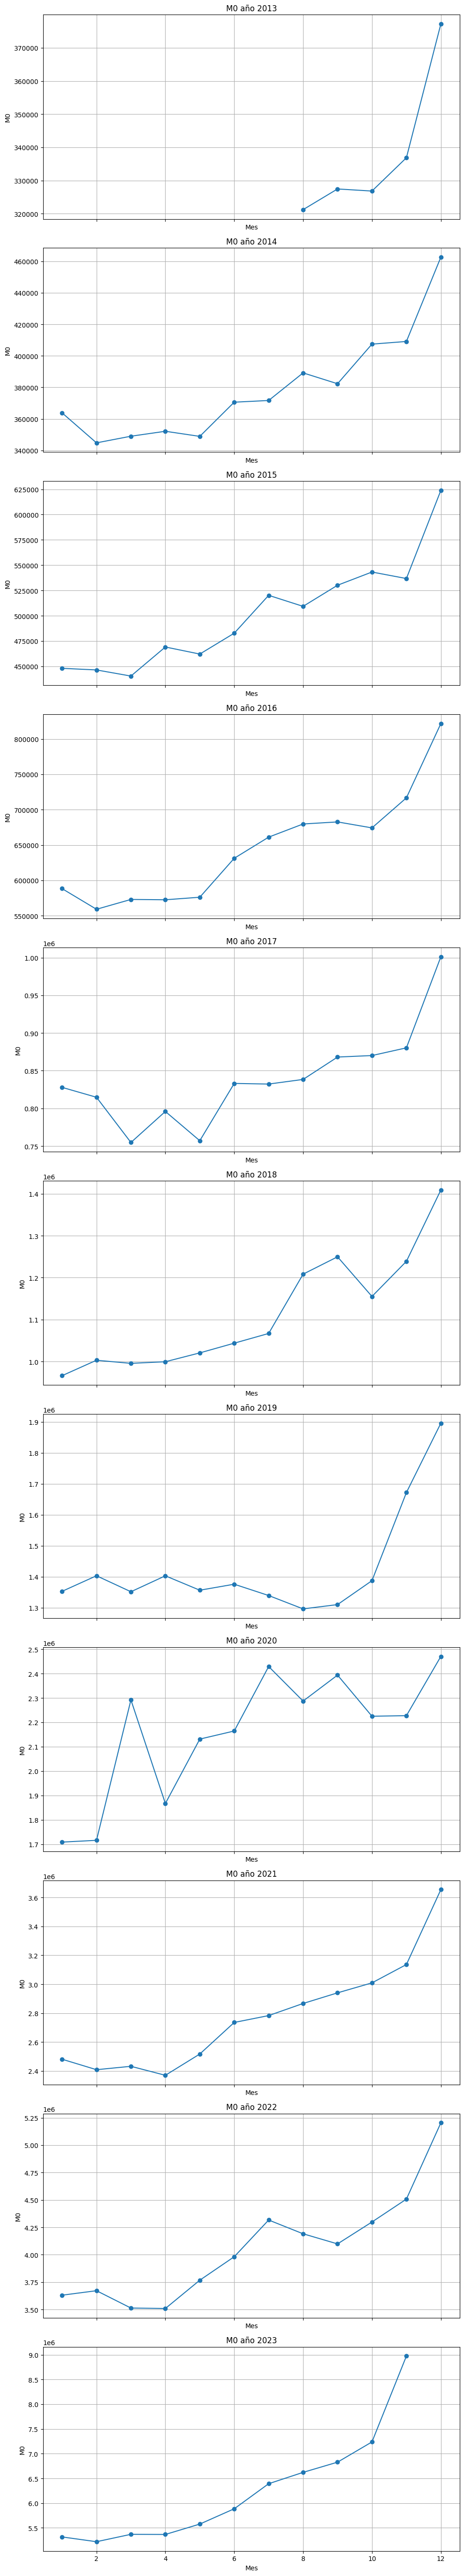

In [ ]:
años = range(2013, 2024)  # Rango de años disponibles
fig, axs = plt.subplots(len(años), 1, figsize=(10, 5 * len(años)), sharex=True)

for i, año in enumerate(años):
    datos_año = datos[str(año)]

    # Paso 3: Graficar la serie de tiempo para cada año en un subplot separado
    ax = axs[i]
    ax.plot(datos_año.index.month, datos_año['M0'], marker='o', linestyle='-')
    ax.set_title(f'M0 año {año}')
    ax.set_ylabel('M0')
    ax.set_xlabel('Mes')
    ax.grid(True)

plt.tight_layout()
plt.show()

## M2

<ipython-input-15-da5c6c934fa7>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=datos.sort_values('date'), x='date', y='M2', estimator=np.sum, ci=None)


Text(0.5, 1.0, 'M2')

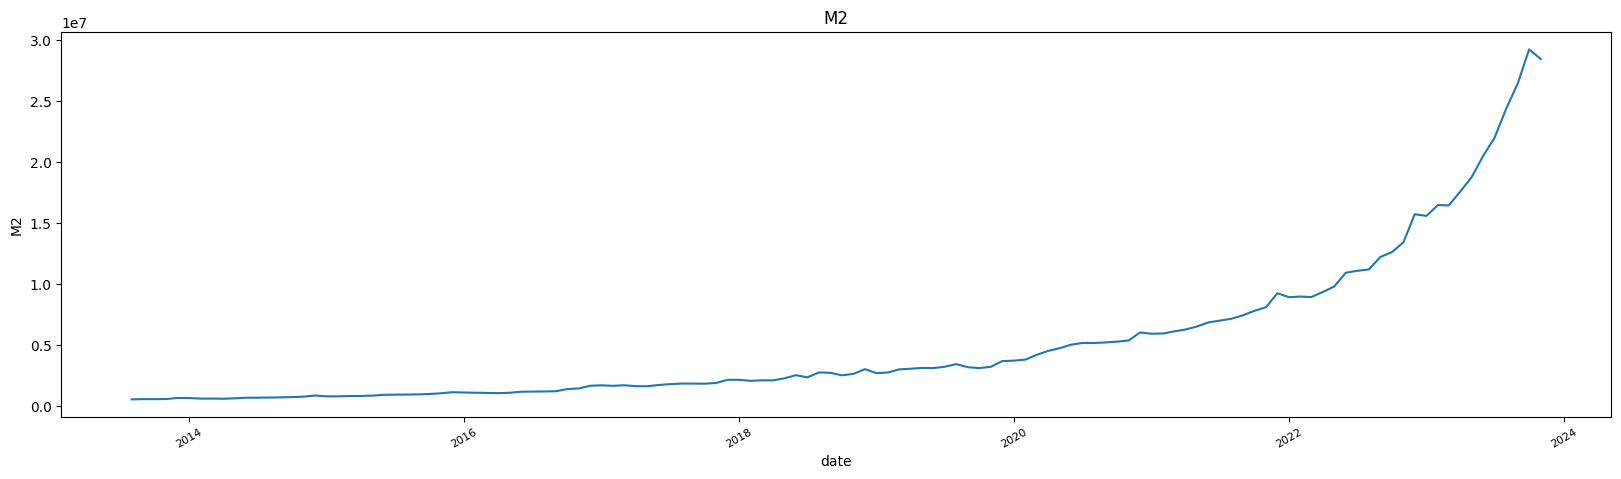

In [ ]:
fig = plt.figure(figsize=(20, 5))

sns.lineplot(data=datos.sort_values('date'), x='date', y='M2', estimator=np.sum, ci=None)
plt.xticks(rotation=30, size=8);
plt.title('M2')

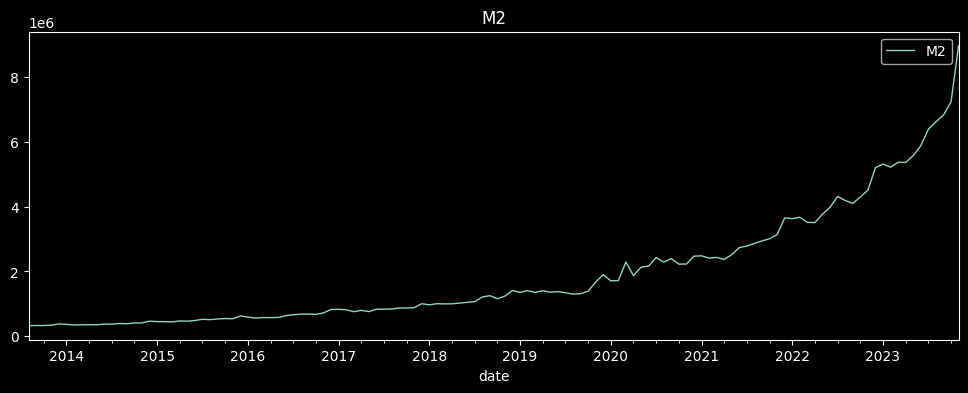

In [ ]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 4))
datos.M0.plot(ax=ax, label='M2', linewidth=1)
ax.set_title('M2')
ax.legend();

<Axes: xlabel='M2'>

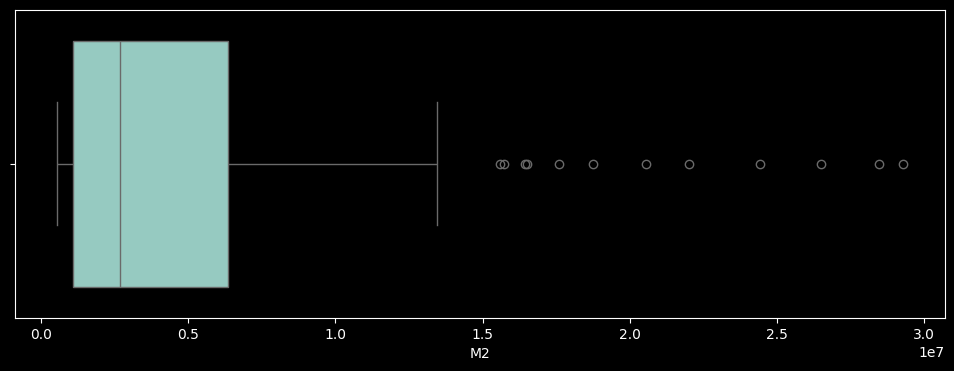

In [ ]:
plt.figure(figsize=(12, 4))
sns.boxplot(x=datos['M2'])

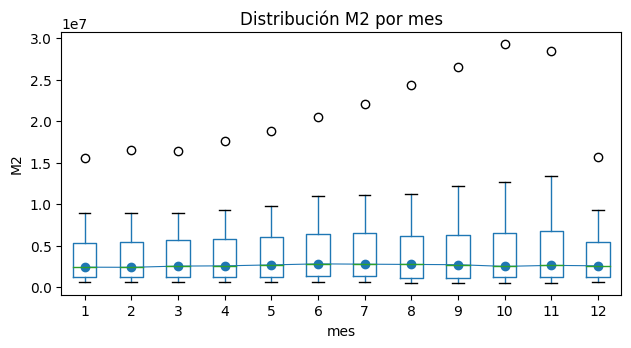

In [ ]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
plt.style.use('default')
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['mes'] = datos.index.month
datos.boxplot(column='M2', by='mes', ax=ax,)
datos.groupby('mes')['M2'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('M2')
ax.set_title('Distribución M2 por mes')
fig.suptitle('');

Valores atípicos:
            IPC_NG  IPC_Nucleo         M0          M2    M2_pesos      M2_ME  \
date                                                                           
2022-12-01  2619.0      2475.0  5203751.0  15741283.0  13088357.0  2652926.0   
2023-01-01  2760.0      2585.0  5316722.0  15600267.0  12771023.0  2829244.0   
2023-02-01  2968.0      2812.0  5219956.0  16497591.0  13550303.0  2947288.0   
2023-03-01  3205.0      3066.0  5369482.0  16454263.0  13436661.0  3017601.0   
2023-04-01  3414.0      3282.0  5366599.0  17599027.0  14573629.0  3025397.0   
2023-05-01  3686.0      3526.0  5576415.0  18765888.0  15518846.0  3247042.0   
2023-06-01  3884.0      3741.0  5885739.0  20541000.0  17075267.0  3465733.0   
2023-07-01  4148.0      4002.0  6392700.0  22010282.0  18158987.0  3851295.0   
2023-08-01  4653.0      4550.0  6621931.0  24406428.0  19801974.0  4604455.0   
2023-09-01  5297.0      5178.0  6828209.0  26491968.0  21875681.0  4616288.0   
2023-10-01  5732.0    

<ipython-input-19-5bc5cc2db807>:9: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  datos_año = datos[str(año)]


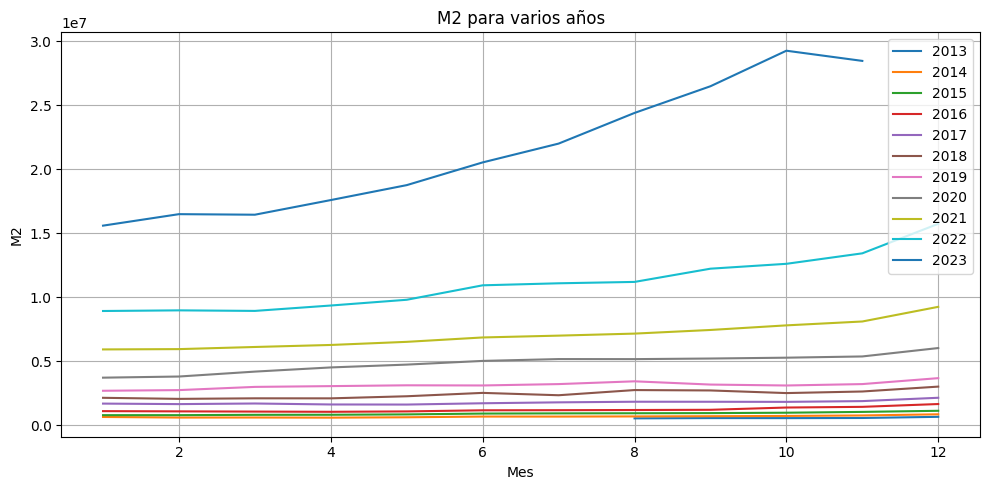

In [ ]:
# Rango de años disponibles
años = range(2013, 2024)

# Crear una figura
plt.figure(figsize=(10, 5))

# Iterar sobre los años y graficar cada uno
for año in años:
    datos_año = datos[str(año)]
    plt.plot(datos_año['mes'], datos_año['M2'], label=str(año))

# Configurar el título, etiquetas de los ejes y leyenda
plt.title('M2 para varios años')
plt.xlabel('Mes')
plt.ylabel('M2')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

<ipython-input-20-6742c6d783c6>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  datos_año = datos[str(año)]


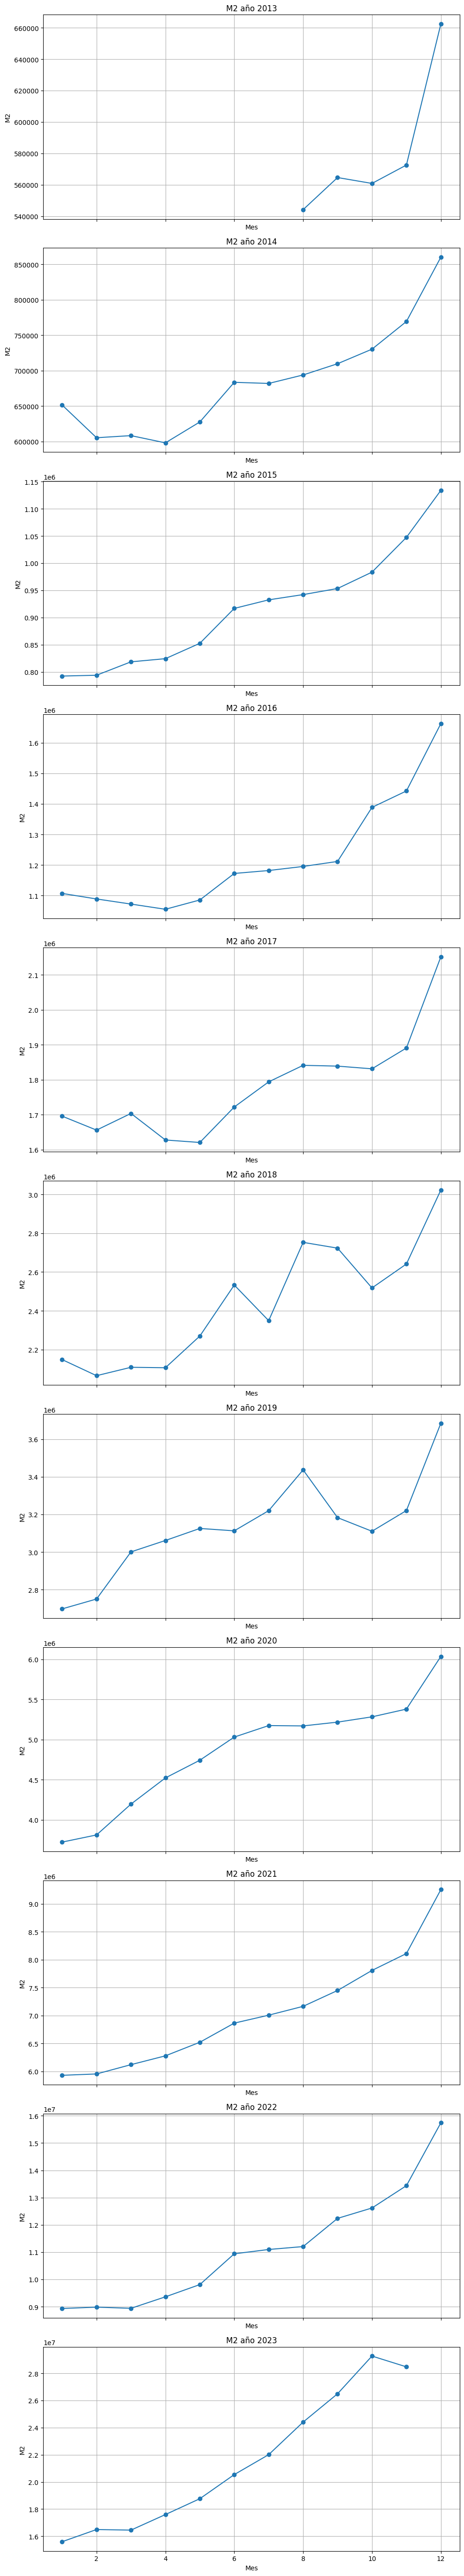

In [ ]:
años = range(2013, 2024)  # Rango de años disponibles
fig, axs = plt.subplots(len(años), 1, figsize=(10, 5 * len(años)), sharex=True)

for i, año in enumerate(años):
    datos_año = datos[str(año)]

    # Paso 3: Graficar la serie de tiempo para cada año en un subplot separado
    ax = axs[i]
    ax.plot(datos_año.index.month, datos_año['M2'], marker='o', linestyle='-')
    ax.set_title(f'M2 año {año}')
    ax.set_ylabel('M2')
    ax.set_xlabel('Mes')
    ax.grid(True)

plt.tight_layout()
plt.show()

## Análisis correlación

In [ ]:
correlation_matrix = datos.corr()

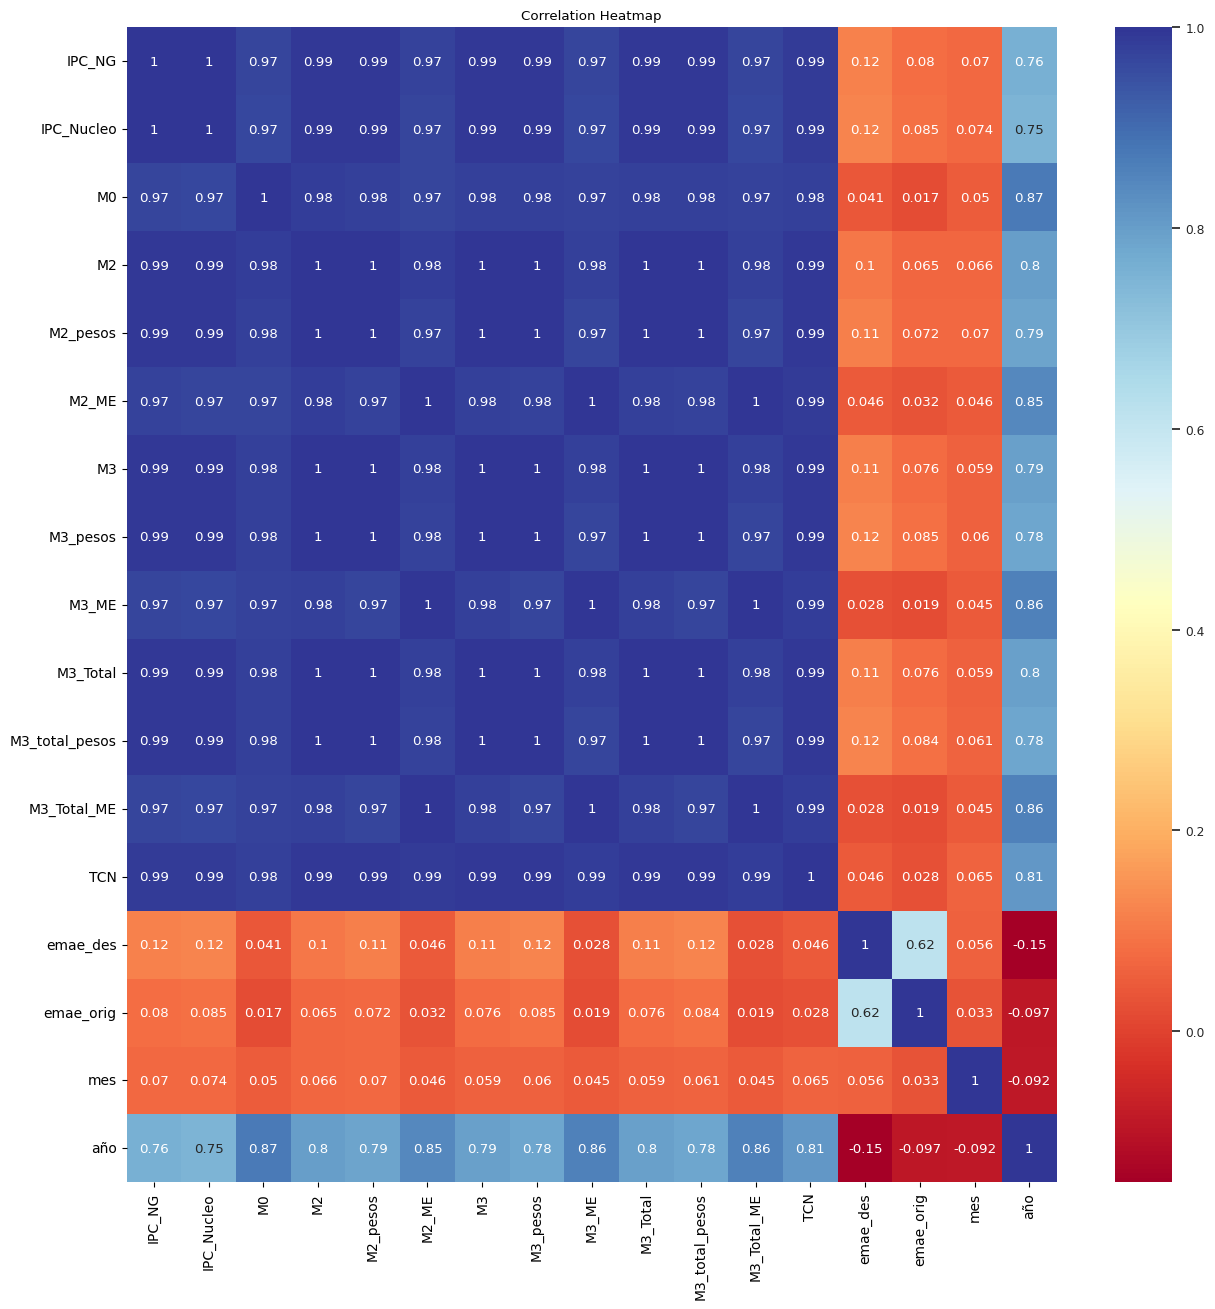

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.set(font_scale=0.8)
#plt.show()

ax =  sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu')
plt.title('Correlation Heatmap')
plt.show()

## Selección columnas

In [ ]:
df_original = datos[['mes','IPC_NG', 'IPC_Nucleo', 'año','M0', 'M2',
        'M3', 'M3_Total',
        'TCN']]

In [ ]:
df = df_original.copy()

# División Train - Test - Validación

In [ ]:
df.describe()

,mes,IPC_NG,IPC_Nucleo,año,M0,M2,M3,M3_Total,TCN
count,124.000000,124.000000,124.000000,124.000000,1.240000e+02,1.240000e+02,1.240000e+02,1.240000e+02,124.000000
mean,6.596774,929.798387,885.008065,2018.241935,1.913642e+06,5.138225e+06,8.660049e+06,8.706844e+06,65.927419
std,3.456864,1218.577746,1184.104591,3.007770,1.801073e+06,6.203887e+06,1.080409e+07,1.085930e+07,78.956319
min,1.000000,100.000000,100.000000,2013.000000,3.211920e+05,5.441460e+05,8.985280e+05,9.000060e+05,6.000000
25%,4.000000,201.500000,196.000000,2016.000000,5.753718e+05,1.088188e+06,1.776266e+06,1.778154e+06,14.000000
50%,7.000000,420.500000,382.500000,2018.000000,1.223584e+06,2.669908e+06,4.359674e+06,4.383463e+06,37.000000
75%,10.000000,1105.250000,1033.750000,2021.000000,2.490282e+06,6.338466e+06,1.068927e+07,1.075392e+07,94.250000
max,12.000000,6471.000000,6365.000000,2023.000000,8.973530e+06,2.926760e+07,4.803651e+07,4.829652e+07,361.000000


In [ ]:
len_df=len(df.IPC_Nucleo)
len_train=round(len_df*0.6)
print('la longitud del conjunto de entrenamiento es:',len_train)
len_test=round(len_df*0.4)
print('la longitud del conjunto de test es:',len_test)
#len_val=len_df - len_train - len_test
#print('la longitud del conjunto de validación es:',len_val)

la longitud del conjunto de entrenamiento es: 74
la longitud del conjunto de test es: 50


In [ ]:
fechas_train = pd.date_range(start=datos.index.min(), periods=len_train, freq='MS')
fechas_test = pd.date_range(start=fechas_train[-1] + pd.DateOffset(months=1), periods=len_test, freq='MS')
#fechas_val=pd.date_range(start=fechas_test[-1] + pd.DateOffset(months=1), periods=25, freq='MS')

print(f"Fechas train : {fechas_train[0]} --- {fechas_train[-1]}  (n={len(datos.loc[:fechas_train[-1]])})")
print(f"Fechas test : {fechas_test[0]} --- {fechas_test[-1]}  (n={len(datos.loc[fechas_test[0]:fechas_test[-1]])})")
#print(f"Fechas validación : {fechas_val[0]} --- {fechas_val[-1]}  (n={len(datos.loc[fechas_val[0]:fechas_val[-1]])})")

Fechas train : 2013-08-01 00:00:00 --- 2019-09-01 00:00:00  (n=74)
Fechas test : 2019-10-01 00:00:00 --- 2023-11-01 00:00:00  (n=50)


In [ ]:
df_train = df.loc[:fechas_train[-1]]
df_test  = df.loc[fechas_test[0]:fechas_test[-1]]
#df_val =  df.loc[fechas_val[0]:fechas_val[-1]]

In [ ]:
x_train = df_train.drop(columns=['IPC_NG', 'IPC_Nucleo'])
y_train = df_train['IPC_NG']

x_test = df_test.drop(columns=['IPC_NG', 'IPC_Nucleo'])
y_test = df_test['IPC_NG']

#x_val = df_val.drop(columns=['IPC_NG', 'IPC_Nucleo'])
#y_val = df_val['IPC_NG']

In [ ]:
print(x_train.shape)
print(y_train.shape)

(74, 7)
(74,)


In [ ]:
print(x_test.shape)
print(y_test.shape)

(50, 7)
(50,)


In [ ]:
#print(x_val.shape)
#print(y_val.shape)

## Gráfico

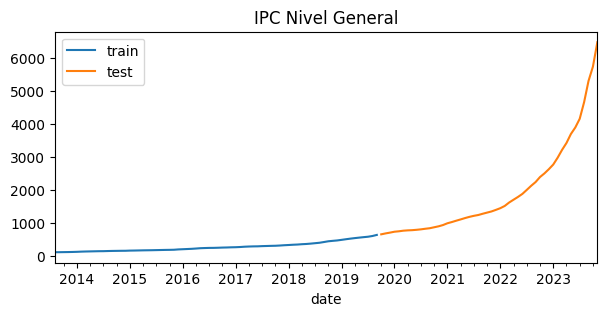

In [ ]:
fig, ax=plt.subplots(figsize=(7,3))
df_train['IPC_NG'].plot(ax=ax,label='train')
df_test ['IPC_NG'].plot(ax=ax, label='test')
#df_val['IPC_NG'].plot(ax=ax, label ='validacion')
ax.set_title('IPC Nivel General')
ax.legend();

# Modelado y evaluación de métricas

#### XGBRegressor

In [ ]:
# Evalúo df_hot con XGBRegressor
model_xgb = XGBRegressor()
model_xgb.fit(x_train, y_train)
y_pred_xgb = model_xgb.predict(x_test)


MAE_xgb = mean_absolute_error(y_test, y_pred_xgb)
MSE_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("Resultados de XGBRegressor:")
print("MAE:", MAE_xgb)
print("MSE:", MSE_xgb)
print("R2:", r2_xgb)

Resultados de XGBRegressor:
MAE: 1311.7286169433594
MSE: 3713345.3113290244
R2: -0.8575422570134725


#### Histogram-Based Gradient Boosting Regressor


In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Crear el modelo HistGradientBoostingRegressor
hist_gb_reg = HistGradientBoostingRegressor()
hist_gb_reg.fit(x_train, y_train)
y_pred_hist_gb = hist_gb_reg.predict(x_test)

# Calcular las métricas de evaluación
MAE_hist_gb = mean_absolute_error(y_test, y_pred_hist_gb)
MSE_hist_gb = mean_squared_error(y_test, y_pred_hist_gb)
r2_hist_gb = r2_score(y_test, y_pred_hist_gb)

print("Resultados de HistGradientBoostingRegressor_Hot:")
print("MAE:", MAE_hist_gb)
print("MSE:", MSE_hist_gb)
print("R2:", r2_hist_gb)

Resultados de HistGradientBoostingRegressor_Hot:
MAE: 1451.4608145331533
MSE: 4105802.203725246
R2: -1.053862609838741


Escalado -- para la técnica que lo requiera

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)



#### Arbol de Decisión

In [ ]:

from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=42)
tree.fit(x_train_scaled, y_train)
tree_pred = tree.predict(x_test_scaled)
tree_mse = mean_squared_error(y_test, tree_pred)
tree_mae = mean_absolute_error(y_test, tree_pred)
tree_r2 = r2_score(y_test, tree_pred)

print("Árbol de Decisión_Hot - MSE:", tree_mse, "MAE:", tree_mae, "R-squared:", tree_r2)

Árbol de Decisión_Hot - MSE: 3713388.14 MAE: 1312.58 R-squared: -0.8575636813786955


####  Red Neuronal

In [ ]:
# Red Neuronal (MLP)

from sklearn.neural_network import MLPRegressor


mlp = MLPRegressor(random_state=42)
mlp.fit(x_train_scaled, y_train)
mlp_pred = mlp.predict(x_test_scaled)
mlp_mse = mean_squared_error(y_test, mlp_pred)
mlp_mae = mean_absolute_error(y_test, mlp_pred)
mlp_r2 = r2_score(y_test, mlp_pred)

print("Red Neuronal (MLP)_Hot - MSE:", mlp_mse, "MAE:", mlp_mae, "R-squared:", mlp_r2)

Red Neuronal (MLP)_Hot - MSE: 4660517.165502869 MAE: 1732.1756241502685 R-squared: -1.3313499953926478


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Regresión Ridge

In [ ]:
# Regresión Ridge

from sklearn.linear_model import LinearRegression, Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(x_train_scaled, y_train)
ridge_pred = ridge.predict(x_test_scaled)
ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_mae = mean_absolute_error(y_test, ridge_pred)
ridge_r2 = r2_score(y_test, ridge_pred)

print("Regresión Ridge_Hot - MSE:", ridge_mse, "MAE:", ridge_mae, "R-squared:", ridge_r2)

Regresión Ridge_Hot - MSE: 475462.6798670463 MAE: 421.5704815527837 R-squared: 0.7621573149172576


#### Light GBM:

In [ ]:
len_df=len(df.IPC_Nucleo)
len_train=round(len_df*0.6)
print('la longitud del conjunto de entrenamiento es:',len_train)
len_test=round(len_df*0.2)
print('la longitud del conjunto de test es:',len_test)
len_val=len_df - len_train - len_test
print('la longitud del conjunto de validación es:',len_val)

la longitud del conjunto de entrenamiento es: 74
la longitud del conjunto de test es: 25
la longitud del conjunto de validación es: 25


In [ ]:
fechas_train = pd.date_range(start=datos.index.min(), periods=len_train, freq='MS')
fechas_test = pd.date_range(start=fechas_train[-1] + pd.DateOffset(months=1), periods=len_test, freq='MS')
fechas_val=pd.date_range(start=fechas_test[-1] + pd.DateOffset(months=1), periods=len_val, freq='MS')

print(f"Fechas train : {fechas_train[0]} --- {fechas_train[-1]}  (n={len(datos.loc[:fechas_train[-1]])})")
print(f"Fechas test : {fechas_test[0]} --- {fechas_test[-1]}  (n={len(datos.loc[fechas_test[0]:fechas_test[-1]])})")
print(f"Fechas validación : {fechas_val[0]} --- {fechas_val[-1]}  (n={len(datos.loc[fechas_val[0]:fechas_val[-1]])})")

Fechas train : 2013-08-01 00:00:00 --- 2019-09-01 00:00:00  (n=74)
Fechas test : 2019-10-01 00:00:00 --- 2021-10-01 00:00:00  (n=25)
Fechas validación : 2021-11-01 00:00:00 --- 2023-11-01 00:00:00  (n=25)


In [ ]:
df_train_LGBM = df.loc[:fechas_train[-1]]
df_test_LGBM  = df.loc[fechas_test[0]:fechas_test[-1]]
df_val_LGBM =  df.loc[fechas_val[0]:fechas_val[-1]]

In [ ]:
x_train_LGBM = df_train_LGBM.drop(columns=['IPC_NG', 'IPC_Nucleo'])
y_train_LGBM = df_train_LGBM['IPC_NG']

x_test_LGBM = df_test_LGBM.drop(columns=['IPC_NG', 'IPC_Nucleo'])
y_test_LGBM = df_test_LGBM['IPC_NG']

x_val_LGBM = df_val_LGBM.drop(columns=['IPC_NG', 'IPC_Nucleo'])
y_val_LGBM = df_val_LGBM['IPC_NG']

In [ ]:
print(x_train_LGBM.shape)
print(y_train_LGBM.shape)

(74, 7)
(74,)


In [ ]:
print(x_test_LGBM.shape)
print(y_test_LGBM.shape)

(25, 7)
(25,)


In [ ]:
print(x_val_LGBM.shape)
print(y_val_LGBM.shape)

(25, 7)
(25,)


In [ ]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

# Split the data into train and validation sets
#x_train, x_valid, y_train, y_valid = train_test_split(x_train_h, y_train_h, test_size=0.2, random_state=42)

# Create LightGBM dataset
train_data = lgb.Dataset(x_train_LGBM, label=y_train_LGBM)
valid_data = lgb.Dataset(x_val_LGBM, label=y_val_LGBM, reference=train_data)


# Define parameters for the LightGBM model
params = {
    'objective': 'regression',  # For binary classification, change this as needed
    'metric': 'mae',  # Use appropriate metric for your problem
    'boosting_type': 'gbdt',
    'max_depth': 10, #Maximum depth of the tree.
    'num_leaves': 30, # The maximum number of leaves in one tree.
    'n_estimators': 350,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1,
    'min_data_in_leaf': 15  # You can add this parameter to control the minimum number of data in a leaf node
}


# Train the LightGBM model
num_round = 100  # You can adjust the number of boosting rounds
bst_h = lgb.train(params, train_data, num_round, valid_sets=[valid_data])
# Enable early stopping
#bst = lgb.early_stopping(stopping_rounds=10, verbose=True)

# Make predictions on the validation set
#y_pred = bst.predict(x_valid_h, num_iteration=bst.best_iteration)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [ ]:
# Make predictions on the validation set
y_lgbm_pred = bst_h.predict(x_val_LGBM, num_iteration=bst_h.best_iteration)

MAE_LGBM = mean_absolute_error(y_val_LGBM, y_lgbm_pred)
MSE_LGBM = mean_squared_error(y_val_LGBM, y_lgbm_pred)
r2_LGBM = r2_score(y_val_LGBM, y_lgbm_pred)
print("Resultados de LightGBM-Regressor-Hot in validation data:")
print("MAE:", MAE_LGBM)
print("MSE:", MSE_LGBM)
print("R2:", r2_LGBM)

# Make predictions on the test set
y_lgbm_pred_test = bst_h.predict(x_test_LGBM, num_iteration=bst_h.best_iteration)

# Compute metrics for the test set
lgbm_MAE_test = mean_absolute_error(y_test_LGBM, y_lgbm_pred_test)
lgbm_MSE_test = mean_squared_error(y_test_LGBM, y_lgbm_pred_test)
lgbm_r2_test= r2_score(y_test_LGBM, y_lgbm_pred_test)

print("Resultados de LightGBM-Regressor-Hot in TEST data:")
print("MAE (Test):", lgbm_MAE_test)
print("MSE (Test):", lgbm_MSE_test)
print("R2 (Test):", lgbm_r2_test)

# Save or use the trained model (if needed)
# bst.save_model('model.txt')


Resultados de LightGBM-Regressor-Hot in validation data:
MAE: 2438.529236025189
MSE: 7938918.520284636
R2: -2.9852227801556195
Resultados de LightGBM-Regressor-Hot in TEST data:
MAE (Test): 455.84923602518916
MSE (Test): 248324.45580949407
R2 (Test): -5.127170008898994


#### Resumen Métricas

In [ ]:
from tabulate import tabulate

# Resultados de XGBRegressor
xgb_results = {
    "Modelo": "XGBRegressor",
    "MAE": MAE_xgb,
    "MSE": MSE_xgb,
    "R2": r2_xgb
}

# Resultados de HistGradientBoostingRegressor
hist_gb_results = {
    "Modelo": "HistGradientBoostingRegressor",
    "MAE": MAE_hist_gb,
    "MSE": MSE_hist_gb,
    "R2": r2_hist_gb
}

# Resultados de Árbol de Decisión
tree_results = {
    "Modelo": "Árbol de Decisión-Hot",
    "MAE": tree_mae,
    "MSE": tree_mse,
    "R2": tree_r2
}


# Resultados de Red Neuronal (MLP)
mlp_results = {
    "Modelo": "Red Neuronal (MLP)",
    "MAE": mlp_mae,
    "MSE": mlp_mse,
    "R2": mlp_r2
}

# Resultados de Regresión Ridge
ridge_results = {
    "Modelo": "Regresión Ridge",
    "MAE": ridge_mae,
    "MSE": ridge_mse,
    "R2": ridge_r2
}

# Resultados de Regresión LightGBM
lgbm_results = {
    "Modelo": "Regresión LightGBM-Hot",
    "MAE": lgbm_MAE_test,
    "MSE": lgbm_MSE_test,
    "R2": lgbm_r2_test
}



# Organiza todos los resultados en una lista
results_list = [xgb_results,  hist_gb_results,
                tree_results, mlp_results,
                ridge_results, lgbm_results]

# Convierte la lista de resultados en un DataFrame usando pandas
results_df = pd.DataFrame(results_list)

In [ ]:
# Ordena el DataFrame por la columna "MAE" de mayor a menor
results_df = results_df.sort_values(by="MAE", ascending=True)

In [ ]:
# Imprimir la tabla usando tabulate
tabla = tabulate(results_df, headers='keys', tablefmt='grid', showindex=False)

print(tabla)

+-------------------------------+----------+------------------+-----------+
| Modelo                        |      MAE |              MSE |        R2 |
+===============================+==========+==================+===========+
| Regresión Ridge               |  421.57  | 475463           |  0.762157 |
+-------------------------------+----------+------------------+-----------+
| Regresión LightGBM-Hot        |  455.849 | 248324           | -5.12717  |
+-------------------------------+----------+------------------+-----------+
| XGBRegressor                  | 1311.73  |      3.71335e+06 | -0.857542 |
+-------------------------------+----------+------------------+-----------+
| Árbol de Decisión-Hot         | 1312.58  |      3.71339e+06 | -0.857564 |
+-------------------------------+----------+------------------+-----------+
| HistGradientBoostingRegressor | 1451.46  |      4.1058e+06  | -1.05386  |
+-------------------------------+----------+------------------+-----------+
| Red Neuron

# Resultados

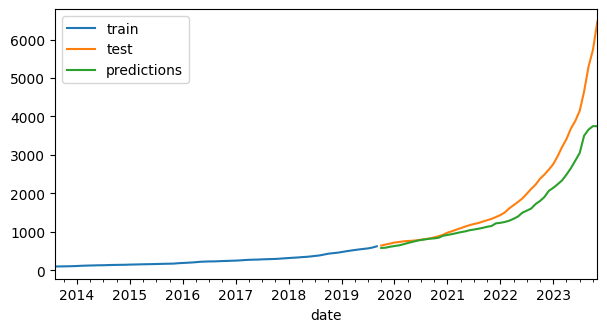

In [ ]:
# Plot predictions
# ==============================================================================
# Convertir ridge_pred a un pandas.Series
ridge_pred_series = pd.Series(ridge_pred, index=y_test.index)

# Graficar
fig, ax = plt.subplots(figsize=(7, 3.5))
y_train.plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
ridge_pred_series.plot(ax=ax, label='predictions')
ax.legend()